### Supplementary

Validation vs. inference skill variability over seeds and epochs.

Use the ACE2-SHiELD training ensemble for data.

In [1]:
from collections import namedtuple

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt, cycler

from constants import SHiELD_TRAINING_RUN_WANDB_IDS, ERA5_TRAINING_RUN_WANDB_IDS, WANDB_ENTITY, WANDB_PROJECT
from utils import wandb_to_xarray, savefig, FONTSIZE, DPI

In [2]:
wandb_api = wandb.Api()
EvalMetric = namedtuple('EvalMetric', ['name', 'long_name'])
METRICS = [
    EvalMetric("train/mean/loss", "training loss"),
    EvalMetric("val/mean/loss", "validation loss"),
    EvalMetric("inference/time_mean_norm/rmse/channel_mean", "channel-mean global RMSE of time-mean normalized error"),
]
METRIC_NAMES = [metric.name for metric in METRICS]
N_EPOCHS_ERA5 = 120
N_EPOCHS_SHiELD = 100 # some trained to 100, but only show 60
STEPS_PER_EPOCH_ERA5 = 6117
STEPS_PER_EPOCH_SHiELD = 12228
MAX_STEPS = N_EPOCHS_ERA5 * STEPS_PER_EPOCH_ERA5 # for plotting
N_SEEDS = 4

In [3]:
era5_metrics = []
for training_run_name, run_id in ERA5_TRAINING_RUN_WANDB_IDS.items():
    metric_ds = wandb_to_xarray(
        WANDB_PROJECT,
        run_id,
        METRIC_NAMES,
        N_EPOCHS_ERA5,
        add_time_coord=False
    )
    era5_metrics.append(metric_ds.expand_dims({'seed': [training_run_name]}))
era5_metrics = xr.concat(era5_metrics, dim='seed')
era5_metrics = era5_metrics.assign_coords(
    {
        'step': era5_metrics._step.isel(seed=0).drop_vars('seed'),
        'epoch': (era5_metrics._step.isel(seed=0).drop_vars('seed') / STEPS_PER_EPOCH_ERA5).astype(int)
    }
)
era5_metrics = (
    era5_metrics
    .swap_dims({'index': 'step'})
    .drop_vars(['index', '_step'])
)

shield_metrics = []
for training_run_name, run_id in SHiELD_TRAINING_RUN_WANDB_IDS.items():
    metric_ds = wandb_to_xarray(
        WANDB_PROJECT,
        run_id,
        METRIC_NAMES,
        N_EPOCHS_SHiELD,
        add_time_coord=False
    )
    shield_metrics.append(metric_ds.expand_dims({'seed': [training_run_name]}))
shield_metrics = xr.concat(shield_metrics, dim='seed')
shield_metrics = shield_metrics.assign_coords(
    {
        'step': shield_metrics._step.isel(seed=0).drop_vars('seed'),
        'epoch': (shield_metrics._step.isel(seed=0).drop_vars('seed') / STEPS_PER_EPOCH_SHiELD).astype(int)
    }
)
shield_metrics = (
    shield_metrics
    .swap_dims({'index': 'step'})
    .drop_vars(['index', '_step'])     
)

In [4]:
# since training loss are the average over an epoch, whereas validation and inference losses are the end of the epoch,
# reindex training loss to 0.5, 1.5, 2.5, ... epochs, and interpolate to 1, 2, ...
# do this in log-log space since the curves are fairly linear there

def get_training_loss_interp(training_loss, steps_per_epoch):
    log_training_loss = np.log2(training_loss)
    log_step = np.log2(training_loss.step.astype(float))
    log_step_minus_half_epoch = np.log2(training_loss.step.astype(float) - 0.5 * steps_per_epoch)
    training_loss_loglog = log_training_loss.assign_coords({'step': log_step_minus_half_epoch})
    training_loss_interp = np.exp2(training_loss_loglog.interp({'step': log_step})).assign_coords({'step': training_loss.step})
    return training_loss_interp


era5_training_loss_raw = era5_metrics["train/mean/loss"]
era5_metrics["train/mean/loss"] = get_training_loss_interp(era5_metrics["train/mean/loss"], STEPS_PER_EPOCH_ERA5)

shield_training_loss_raw = shield_metrics["train/mean/loss"]
shield_metrics["train/mean/loss"] = get_training_loss_interp(shield_metrics["train/mean/loss"], STEPS_PER_EPOCH_SHiELD)

In [5]:
plt.rc('font', size=FONTSIZE)
plt.rc('figure', dpi=DPI)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 2))
plt.rc('ytick', labelsize=(FONTSIZE - 2))
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0
plt.rc('lines', linewidth=0.75)

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_cycler = (
    cycler(linestyle=(['-', ':'])) *
    cycler(color=[colors[i] for i in [0, 1, 2, 5]])
)
plt.rc('axes', prop_cycle=custom_cycler)

In [7]:
shield_metrics

<xarray.Dataset> Size: 11kB
Dimensions:                                     (seed: 4, step: 100)
Coordinates:
  * seed                                        (seed) object 32B 'rs0' ... '...
  * step                                        (step) float64 800B 1.223e+04...
    epoch                                       (step) int64 800B 1 2 ... 99 100
Data variables:
    train/mean/loss                             (seed, step) float64 3kB 0.39...
    val/mean/loss                               (seed, step) float64 3kB 0.29...
    inference/time_mean_norm/rmse/channel_mean  (seed, step) float64 3kB 0.14...

In [8]:
def to_shield_epoch(step):
    return step / STEPS_PER_EPOCH_SHiELD
    
def to_era5_epoch(step):
    return step / STEPS_PER_EPOCH_ERA5

def from_shield_epoch(epoch):
    return epoch * STEPS_PER_EPOCH_SHiELD

def from_era5_epoch(epoch):
    return epoch * STEPS_PER_EPOCH_ERA5

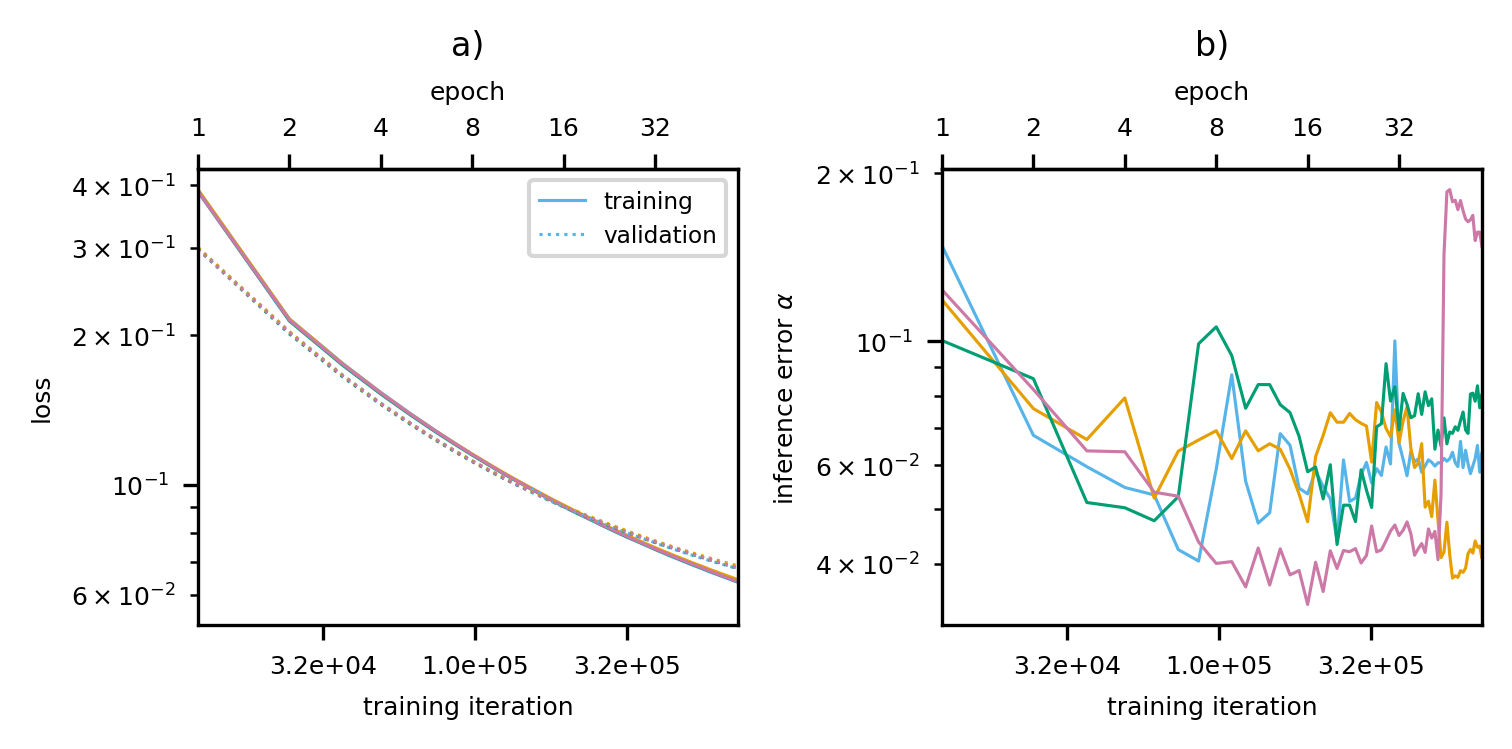

In [9]:
step_ticks = np.logspace(4, 6, 5)
step_ticks_labels = [f"{i:.1e}" for i in step_ticks]
epoch_ticks = np.logspace(0, 6, 7, base=2)
epoch_ticks_labels = [int(i) for i in epoch_ticks]
figsize = [1.27 * i for i in [4.0, 2.0]]

fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
ax0 = axes.flatten()[0]
hts = shield_metrics['train/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False)
hvs = shield_metrics['val/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel('training iteration')
ax0.set_ylabel('loss')
ax0.set_xticks(step_ticks)
ax0.set_xticklabels(step_ticks_labels)
ax0.set_xlim([STEPS_PER_EPOCH_SHiELD, MAX_STEPS])
ax0.set_title('a)')
ax0t = ax0.secondary_xaxis('top', functions=(to_shield_epoch, from_shield_epoch))
ax0t.set_xticks(epoch_ticks)
ax0t.set_xticklabels(epoch_ticks_labels)
ax0t.set_xlabel('epoch')
ax0.legend([hts[0],  hvs[0]], ['training', 'validation'], fontsize='x-small')
ax1 = axes.squeeze()[1]
his = shield_metrics['inference/time_mean_norm/rmse/channel_mean'].plot(hue='seed', ax=ax1, add_legend=False)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('training iteration')
ax1.set_ylabel(r'inference error $\alpha$')
ax1.set_xticks(step_ticks)
ax1.set_xticklabels(step_ticks_labels)
ax1.set_xlim([STEPS_PER_EPOCH_SHiELD, MAX_STEPS])
ax1.set_title('b)')
ax1t = ax1.secondary_xaxis('top', functions=(to_shield_epoch, from_shield_epoch))
ax1t.set_xticks(epoch_ticks)
ax1t.set_xticklabels(epoch_ticks_labels)
ax1t.set_xlabel('epoch')
fig.tight_layout()
savefig(fig, 'supplementary_ace2_shield_training.png')

In [10]:
era5_colors = plt.get_cmap('Greens')(np.linspace(0.5, 1, N_SEEDS))
shield_colors = plt.get_cmap('Oranges')(np.linspace(0.5, 1, N_SEEDS))
colors = np.vstack([era5_colors, shield_colors])
custom_cycler = (
    cycler(linestyle=(['-', ':'])) *
    cycler(color=colors)
)
plt.rc('axes', prop_cycle=custom_cycler)

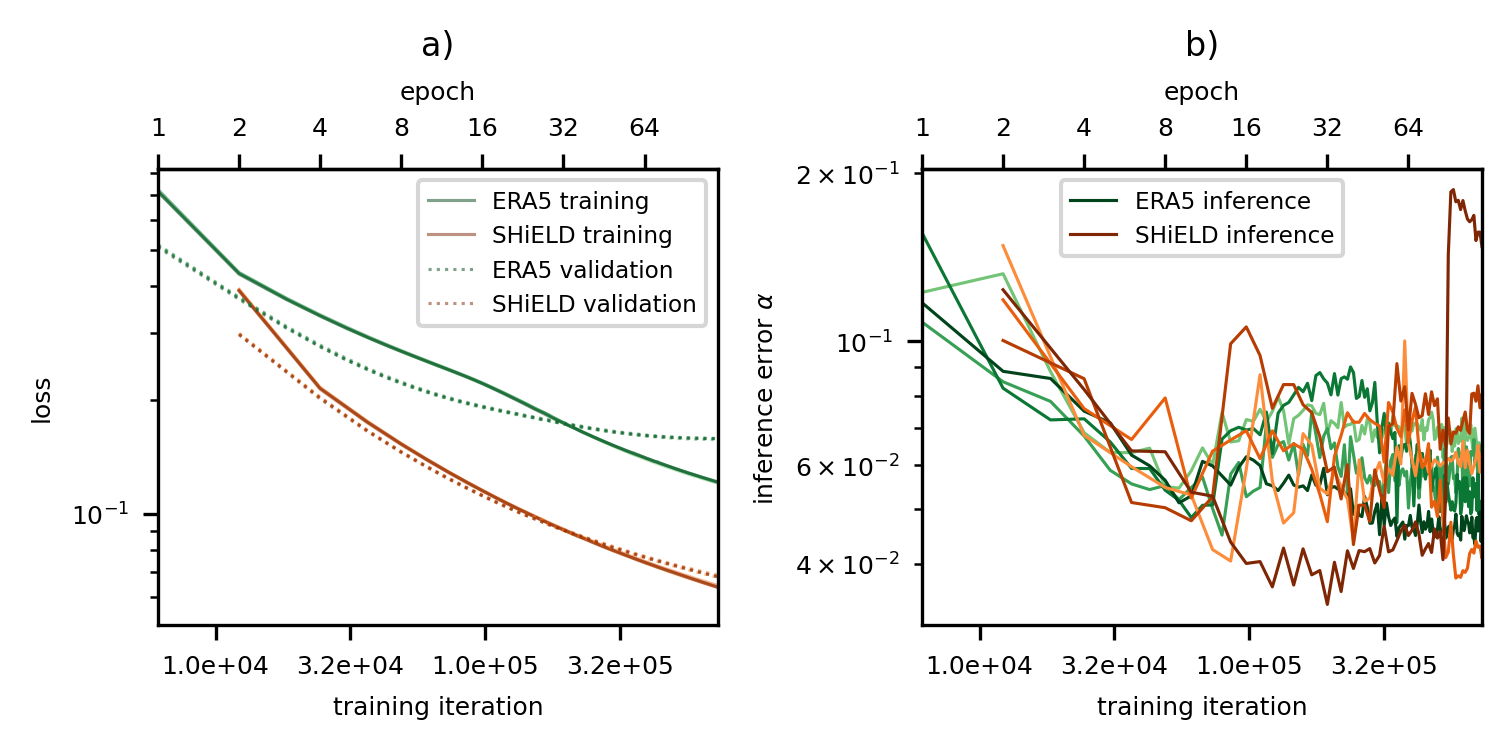

In [11]:
step_ticks = np.logspace(4, 6, 5)
step_ticks_labels = [f"{i:.1e}" for i in step_ticks]
figsize = [1.27 * i for i in [4.0, 2.0]]

fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
ax0 = axes.flatten()[0]
hte = era5_metrics['train/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False, alpha=0.5)
hts = shield_metrics['train/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False, alpha=0.5)
hve = era5_metrics['val/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False, alpha=0.5)
hvs = shield_metrics['val/mean/loss'].plot(hue='seed', ax=ax0, add_legend=False, alpha=0.5)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel('training iteration')
ax0.set_ylabel('loss')
ax0.set_xticks(step_ticks)
ax0.set_xticklabels(step_ticks_labels)
ax0.set_xlim([STEPS_PER_EPOCH_ERA5, MAX_STEPS])
ax0.set_title('a)')
ax0t = ax0.secondary_xaxis('top', functions=(to_era5_epoch, from_era5_epoch))
ax0t.set_xticks(epoch_ticks)
ax0t.set_xticklabels(epoch_ticks_labels)
ax0t.set_xlabel('epoch')
ax0.legend([hte[-1], hts[-1], hve[-1], hvs[-1]], ['ERA5 training', 'SHiELD training', 'ERA5 validation', 'SHiELD validation'], fontsize='x-small')
ax1 = axes.squeeze()[1]
hie = era5_metrics['inference/time_mean_norm/rmse/channel_mean'].plot(hue='seed', ax=ax1)
his = shield_metrics['inference/time_mean_norm/rmse/channel_mean'].plot(hue='seed', ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('training iteration')
ax1.set_ylabel(r'inference error $\alpha$')
ax1.set_xticks(step_ticks)
ax1.set_xticklabels(step_ticks_labels)
ax1.set_xlim([STEPS_PER_EPOCH_ERA5, MAX_STEPS])
ax1.set_title('b)')
ax1t = ax1.secondary_xaxis('top', functions=(to_era5_epoch, from_era5_epoch))
ax1t.set_xticks(epoch_ticks)
ax1t.set_xticklabels(epoch_ticks_labels)
ax1t.set_xlabel('epoch')
ax1.legend([hie[-1], his[-1]], ['ERA5 inference', 'SHiELD inference'], fontsize='x-small')
fig.tight_layout()
savefig(fig, 'supplementary_ace2_era5_shield_training.png')